# Data preprocessing

Using dataset National Flowers, which has 9 classes of flowers:

- daisy
- dandelion
- lavender
- lilly
- lotus
- orchid
- rose
- sunflower
- tulip
---------

## Loading data

We need to load data and split it into 3 pieces:
- 20% test
- 16% validation
- 64% train

In [15]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

In [16]:
# Train data normalizing and augmentation settings:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
# Val and test data normalizing and augmentation settings:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [53]:
dataset_path = "/kaggle/input/national-flowers/flowerdataset/"
best_models_path = "/kaggle/working/best_models"
if not os.path.exists(best_models_path):
    os.makedirs(best_models_path)
class_names = os.listdir(os.path.join(dataset_path, 'train'))
number_of_classes = len(class_names)

In [19]:
# 1. Load and transform as training all train data
full_train_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'), transform=train_transform)

In [20]:
# 2. Split train data into train and validation data
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [21]:
# 3. Load and transform as validation only already splitted val data
val_dataset = Subset(datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'), transform=val_test_transform), val_dataset.indices)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [22]:
# 4. Load and transform as testing all test data
test_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'test'), transform=val_test_transform)

## Generating data batches

In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# Function to colorize output
def colored_print(text: str, color: str = 'grey'):
    if color == 'grey':
        print(f"\033[90m{text}\033[0m")
    elif color == 'r':
        print(f"\033[91m{text}\033[0m")
    elif color == 'g':
        print(f"\033[92m{text}\033[0m")
    elif color == 'y':
        print(f"\033[93m{text}\033[0m")
    elif color == 'm':
        print(f"\033[95m{text}\033[0m")
    elif color == 'c':
        print(f"\033[96m{text}\033[0m")

# Building and training models

We are going to build, train and score 4 models:

- simple custom CNN model
- pretrained ResNet50
- pretrained MobileNet
- pretrained EfficientNet

## Simple CNN

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [26]:
# Initialising a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, number_of_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 112 * 112, number_of_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 112 * 112)
        x = self.fc1(x)
        return x

In [41]:
def train_cnn():
    colored_print(f'Simple CNN', 'g')
    # using GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    colored_print(f'Using device: {device}')

    cnn = SimpleCNN(number_of_classes).to(device)

    # defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)

    # training a model
    epochs = 20
    best_cnn_params = dict({})
    best_cnn_accuracy = 0
    for epoch in range(epochs):
        cnn.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'\nEpoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.2f}')

        # validation
        cnn.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = cnn(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.2f}, Accuracy: {validation_accuracy:.2f}')
        
        # save params if accuracy is better
        if validation_accuracy > best_cnn_accuracy:
            best_cnn_accuracy = validation_accuracy
            best_cnn_params = cnn.state_dict()
            
        
    # load params with the best accuracy
    cnn.load_state_dict(best_cnn_params)
    colored_print(f'\nBest accuracy achived: {best_cnn_accuracy}', 'g')
    return cnn
    
cnn = train_cnn()

Training simple CNN model
Using device: cuda

Epoch [1/20], Loss: 26.28
Validation Loss: 12.41, Accuracy: 33.61

Epoch [2/20], Loss: 7.56
Validation Loss: 7.31, Accuracy: 40.42

Epoch [3/20], Loss: 5.17
Validation Loss: 4.04, Accuracy: 46.39

Epoch [4/20], Loss: 3.66
Validation Loss: 3.41, Accuracy: 45.83

Epoch [5/20], Loss: 2.85
Validation Loss: 2.98, Accuracy: 46.67

Epoch [6/20], Loss: 2.51
Validation Loss: 2.75, Accuracy: 46.39

Epoch [7/20], Loss: 2.22
Validation Loss: 2.69, Accuracy: 50.00

Epoch [8/20], Loss: 1.96
Validation Loss: 2.57, Accuracy: 48.75

Epoch [9/20], Loss: 1.95
Validation Loss: 2.29, Accuracy: 51.39

Epoch [10/20], Loss: 1.58
Validation Loss: 2.20, Accuracy: 50.14

Epoch [11/20], Loss: 1.53
Validation Loss: 1.89, Accuracy: 52.36

Epoch [12/20], Loss: 1.44
Validation Loss: 1.75, Accuracy: 55.83

Epoch [13/20], Loss: 1.37
Validation Loss: 1.93, Accuracy: 52.36

Epoch [14/20], Loss: 1.33
Validation Loss: 1.69, Accuracy: 53.19

Epoch [15/20], Loss: 1.25
Validation 

In [48]:
torch.save(cnn.state_dict(), os.path.join(best_models_path, 'cnn.pth'))

## ResNet50

# Score models

*You need to initialize all models' classes.*

- initialize a model's object
- load best params from /best_models/model.pth
- model is ready to be evaluated

## Score function

In [49]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
def score_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, f1, conf_matrix

In [90]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):   
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('PREDICTED')
    plt.ylabel('TRUE')
    plt.title(f'{model_name} Confusion Matrix')
    
    plt.text(0.5, -0.1, f'accuracy: {accuracy:.2f}', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=10)
    plt.show()

## Score Simple CNN

In [ ]:
# path to best params
best_cnn_params_path = os.path.join(best_models_path, 'cnn.pth')

# load best params into model
cnn = SimpleCNN(number_of_classes)
cnn.load_state_dict(torch.load(save_path))

In [58]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

# model is ready for use

In [67]:
cnn_accuracy, cnn_f1_score, cnn_confusion_matrix = score_model(cnn)

Accuracy: 0.46, f1-score: 0.44


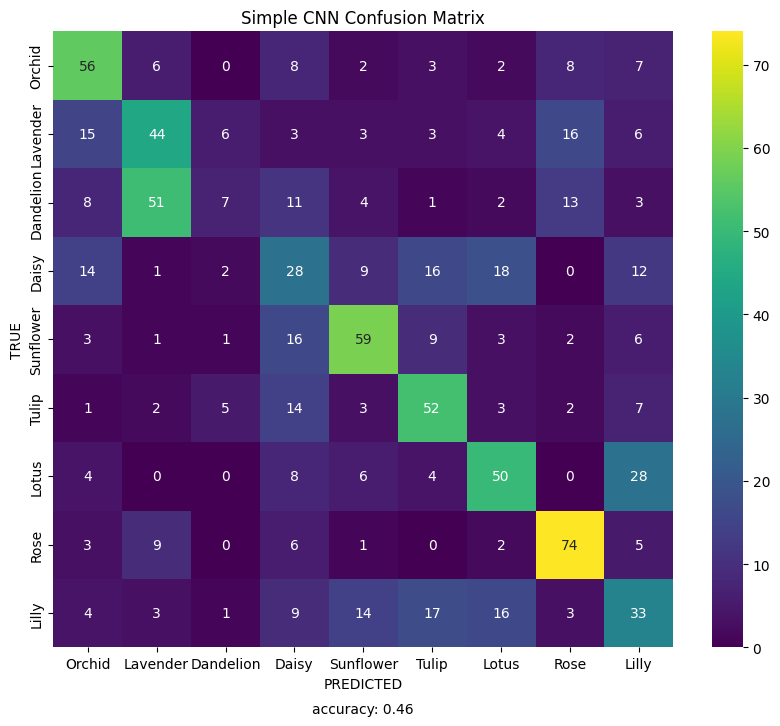

In [91]:
colored_print(f'Accuracy: {cnn_accuracy:.2f}, f1-score: {cnn_f1_score:.2f}', 'g')
plot_confusion_matrix(cnn_confusion_matrix, 'Simple CNN', cnn_accuracy)